<a href="https://colab.research.google.com/github/christophergaughan/Strategic-Glycan-Engineering-Scanner/blob/main/Strategic_Glycan_Engineering_for_RFdiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strategic Glycan Engineering for RFdiffusion Antibodies

**Enhancing ML-Designed Antibodies with Strategic Post-Translational Modifications**

Christopher Gaughan, PhD  
AntibodyML Consulting LLC

---

## The Problem: RFdiffusion is Glycan-Blind

Current ML antibody design tools (RFdiffusion, AlphaFold3, Chai-1) optimize for **binding affinity** but completely ignore **post-translational modifications**:

- ✅ Generate sequences with excellent predicted binding
- ❌ No consideration of glycosylation patterns
- ❌ No awareness of expression/manufacturing constraints
- ❌ Result: Designs that work *in silico* but fail in bioreactors

**The Gap:** 79-86% of glycosylation sites emerge from positions that are **one mutation away** from N-X-S/T motifs, yet ML tools never see them coming.

---

## The Solution: Strategic Glycan Engineering

**Instead of avoiding glycosylation, we engineer it strategically:**

1. **RFdiffusion** generates optimized antibody sequence
2. **Scanner** identifies positions where single mutations create N-X-S/T motifs
3. **Engineer** those mutations (D→N, V→T, etc.) to add glycans
4. **MD simulations** validate glycan addition doesn't disrupt binding
5. **Result:** Antibodies optimized for BOTH binding AND expression

---

## Key Innovation: Evolutionarily Accessible Sites

We prioritize positions by **somatic hypermutation (SHM) probability:**

- **D→N mutations** (16.5% probability): Highest priority
- **A→S, V→T mutations** (5-10% probability): Medium priority
- High mutation probability = evolutionarily tolerated position
- Immune system already "tests" these changes naturally

**Strategic glycosylation can:**
- Reduce aggregation and improve solubility
- Modulate binding kinetics and specificity
- Control immunogenicity
- Improve manufacturability and stability

## Setup: Install Dependencies

In [1]:
# Google Colab Setup
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Setting up Google Colab environment...")
    !pip install biopython pandas numpy matplotlib seaborn --quiet
    !apt-get update -qq > /dev/null 2>&1
    !apt-get install -y dssp > /dev/null 2>&1
    print("✓ Setup complete!")
else:
    print("📍 Running locally - ensure biopython, pandas, numpy, matplotlib, seaborn are installed")

🔧 Setting up Google Colab environment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.1 MB/s eta 0:00:00
✓ Setup complete!


## Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional

print("✓ All packages loaded successfully")

✓ All packages loaded successfully


---
# Part 1: Somatic Hypermutation Database

Mutation probabilities from SHM literature (Kepler et al., Yaari et al., McCoy et al.)  
**Higher probability = More evolutionarily accessible = Better engineering target**

In [3]:
# Codon-specific mutation probabilities for glycosylation engineering
MUTATION_PROBABILITIES = {
    # D→N mutations (Type 1) - HIGHEST PRIORITY
    'D_to_N': {
        'GAT_to_AAT': 0.18,  # G→A transition in WRC hotspot
        'GAC_to_AAC': 0.15,
        'average': 0.165
    },

    # Hydrophobic→Serine/Threonine (Type 2) - MEDIUM PRIORITY
    'A_to_S': {'average': 0.10},
    'V_to_T': {'average': 0.08},
    'I_to_T': {'average': 0.057},
    'L_to_S': {'average': 0.055}
}

def get_mutation_probability(aa_from: str, aa_to: str) -> float:
    """Get SHM probability for amino acid change."""
    key = f"{aa_from}_to_{aa_to}"
    return MUTATION_PROBABILITIES.get(key, {}).get('average', 0.01)

print("✓ SHM probability database loaded")
print("\n📊 Engineering Priority:")
print(f"  🥇 D→N (highest): {MUTATION_PROBABILITIES['D_to_N']['average']:.1%}")
print(f"  🥈 A→S: {MUTATION_PROBABILITIES['A_to_S']['average']:.1%}")
print(f"  🥉 V→T: {MUTATION_PROBABILITIES['V_to_T']['average']:.1%}")
print("\n💡 Higher probability = More tolerated by evolution = Better engineering target")

✓ SHM probability database loaded

📊 Engineering Priority:
  🥇 D→N (highest): 16.5%
  🥈 A→S: 10.0%
  🥉 V→T: 8.0%

💡 Higher probability = More tolerated by evolution = Better engineering target


---
# Part 2: Glycan Engineering Scanner

Identifies positions where single mutations create N-X-S/T glycosylation motifs.  
**Purpose:** Find accessible sites for strategic glycan addition in RFdiffusion designs.

In [4]:
class GlycanEngineeringScanner:
    """
    Scanner for identifying accessible glycosylation engineering sites.

    Finds positions where single somatic hypermutations can create N-X-S/T motifs,
    prioritized by evolutionary accessibility and CDR proximity.
    """

    # IMGT CDR boundaries (approximate)
    CDR_BOUNDARIES_VH = {
        'CDR1': (27, 38),
        'CDR2': (56, 65),
        'CDR3': (105, 117),
    }

    CDR_BOUNDARIES_VL = {
        'CDR1': (27, 38),
        'CDR2': (56, 65),
        'CDR3': (105, 117),
    }

    def __init__(self):
        """Initialize scanner."""
        print("✓ Glycan Engineering Scanner initialized")
        print("  Mode: Strategic PTM engineering for RFdiffusion antibodies")

    def has_glycosylation_motif(self, aa_seq: str, position: int) -> bool:
        """Check if position contains N-X-S/T motif (X ≠ P)."""
        if position + 2 >= len(aa_seq):
            return False
        return (aa_seq[position] == 'N' and
                aa_seq[position + 1] != 'P' and
                aa_seq[position + 2] in ['S', 'T'])

    def scan_existing_sites(self, aa_sequence: str) -> List[Dict]:
        """Find existing N-X-S/T glycosylation motifs (already present in design)."""
        sites = []
        for i in range(len(aa_sequence) - 2):
            if self.has_glycosylation_motif(aa_sequence, i):
                sites.append({
                    'position': i + 1,  # 1-indexed
                    'motif': aa_sequence[i:i+3],
                    'type': 'EXISTING',
                    'mutation_from': None,
                    'mutation_to': None,
                    'mutation_prob': None
                })
        return sites

    def scan_accessible_sites(self, aa_sequence: str) -> List[Dict]:
        """
        Find accessible sites: positions one mutation away from N-X-S/T.

        These are ENGINEERING OPPORTUNITIES where you can add glycans.

        Type 1: D-X-S/T → N-X-S/T (D→N mutation) - HIGH PRIORITY
        Type 2: N-X-A/V/I/L → N-X-S/T (hydrophobic→S/T mutation) - MEDIUM PRIORITY
        """
        sites = []

        for i in range(len(aa_sequence) - 2):
            window = aa_sequence[i:i+3]

            # Type 1: D-X-S/T (D→N creates N-X-S/T)
            if window[0] == 'D' and window[1] != 'P' and window[2] in ['S', 'T']:
                sites.append({
                    'position': i + 1,
                    'motif': window,
                    'type': 'ACCESSIBLE_TYPE1',
                    'mutation_from': 'D',
                    'mutation_to': 'N',
                    'mutation_prob': get_mutation_probability('D', 'N'),
                    'recommended_mutation': f'D{i+1}N'
                })

            # Type 2: N-X-A/V/I/L (A/V/I/L→S/T creates N-X-S/T)
            if window[0] == 'N' and window[1] != 'P' and window[2] in ['A', 'V', 'I', 'L']:
                aa_from = window[2]
                # Pick best mutation (S or T)
                prob_s = get_mutation_probability(aa_from, 'S')
                prob_t = get_mutation_probability(aa_from, 'T')
                best_to = 'S' if prob_s >= prob_t else 'T'
                best_prob = max(prob_s, prob_t)

                sites.append({
                    'position': i + 1,
                    'motif': window,
                    'type': 'ACCESSIBLE_TYPE2',
                    'mutation_from': aa_from,
                    'mutation_to': best_to,
                    'mutation_prob': best_prob,
                    'recommended_mutation': f'{aa_from}{i+3}{best_to}'
                })

        return sites

    def check_cdr_proximity(self, position: int, chain_type: str = 'H') -> Dict:
        """
        Check if position is in or near CDR regions.

        CDR proximity affects functional impact:
        - IN CDR: Direct modulation of binding interface
        - NEAR CDR: May influence CDR conformation
        - Framework: Primarily affects stability/solubility
        """
        boundaries = self.CDR_BOUNDARIES_VH if chain_type == 'H' else self.CDR_BOUNDARIES_VL

        proximity = {
            'in_cdr': False,
            'cdr_region': None,
            'near_cdr': False,
            'distance_to_cdr': None
        }

        min_distance = float('inf')

        for cdr_name, (start, end) in boundaries.items():
            if start <= position <= end:
                proximity['in_cdr'] = True
                proximity['cdr_region'] = cdr_name
                proximity['distance_to_cdr'] = 0
                return proximity

            # Calculate distance to this CDR
            if position < start:
                distance = start - position
            else:
                distance = position - end

            if distance < min_distance:
                min_distance = distance
                proximity['cdr_region'] = cdr_name

        proximity['distance_to_cdr'] = min_distance
        proximity['near_cdr'] = min_distance <= 5

        return proximity

    def calculate_engineering_priority(self, site: Dict, proximity: Dict) -> float:
        """
        Calculate engineering priority score.

        HIGH SCORE = HIGH PRIORITY for testing in MD simulations

        Priority factors:
        1. Mutation probability (evolutionary accessibility)
        2. CDR proximity (functional relevance)
        3. Site type (existing vs accessible)
        """
        # Base priority from site type
        if site['type'] == 'EXISTING':
            base_priority = 30.0  # Already has glycan
        elif site['type'] == 'ACCESSIBLE_TYPE1':
            # Weight by D→N mutation probability (16.5%)
            base_priority = 15.0 * site['mutation_prob'] / 0.165
        else:  # TYPE2
            # Weight by hydrophobic→S/T probability (5-10%)
            base_priority = 10.0 * site['mutation_prob'] / 0.08

        # CDR proximity multiplier (higher = more impact on binding)
        if proximity['in_cdr']:
            multiplier = 3.0  # Direct binding interface modulation
        elif proximity['near_cdr']:
            multiplier = 2.0  # May influence CDR conformation
        else:
            multiplier = 1.0  # Framework - stability/solubility

        return base_priority * multiplier

    def scan_chain(self, aa_sequence: str, chain_type: str = 'H') -> Dict:
        """
        Scan single antibody chain for engineering opportunities.

        Args:
            aa_sequence: Amino acid sequence
            chain_type: 'H' for heavy, 'L' for light

        Returns:
            Engineering opportunities with priority ranking
        """
        existing_sites = self.scan_existing_sites(aa_sequence)
        accessible_sites = self.scan_accessible_sites(aa_sequence)

        all_sites = []

        for site in existing_sites + accessible_sites:
            proximity = self.check_cdr_proximity(site['position'], chain_type)
            priority_score = self.calculate_engineering_priority(site, proximity)

            site['proximity'] = proximity
            site['priority_score'] = priority_score
            all_sites.append(site)

        # Sort by priority score (highest first)
        all_sites.sort(key=lambda x: x['priority_score'], reverse=True)

        # Summary statistics
        existing_count = len([s for s in all_sites if s['type'] == 'EXISTING'])
        accessible_count = len([s for s in all_sites if 'ACCESSIBLE' in s['type']])
        cdr_sites = len([s for s in all_sites if s['proximity']['in_cdr']])
        total_priority = sum(s['priority_score'] for s in all_sites)

        return {
            'chain_type': chain_type,
            'length': len(aa_sequence),
            'sites': all_sites,
            'summary': {
                'total_sites': len(all_sites),
                'existing_sites': existing_count,
                'accessible_sites': accessible_count,
                'cdr_sites': cdr_sites,
                'total_priority': total_priority
            }
        }

    def scan_antibody(self, heavy_chain: str, light_chain: str,
                     antibody_name: str = "Unknown") -> Dict:
        """
        Complete antibody scan for glycan engineering opportunities.

        Args:
            heavy_chain: Heavy chain sequence
            light_chain: Light chain sequence
            antibody_name: Name for reporting

        Returns:
            Complete analysis with prioritized engineering recommendations
        """
        heavy_results = self.scan_chain(heavy_chain, 'H')
        light_results = self.scan_chain(light_chain, 'L')

        total_priority = (heavy_results['summary']['total_priority'] +
                         light_results['summary']['total_priority'])

        total_existing = (heavy_results['summary']['existing_sites'] +
                         light_results['summary']['existing_sites'])

        total_accessible = (heavy_results['summary']['accessible_sites'] +
                           light_results['summary']['accessible_sites'])

        total_cdr = (heavy_results['summary']['cdr_sites'] +
                    light_results['summary']['cdr_sites'])

        # Engineering assessment
        if total_accessible >= 5:
            assessment = 'EXCELLENT'
            recommendation = '🎯 EXCELLENT: Multiple accessible sites for strategic glycan engineering.'
        elif total_accessible >= 3:
            assessment = 'GOOD'
            recommendation = '✓ GOOD: Several engineering opportunities available.'
        else:
            assessment = 'LIMITED'
            recommendation = '⚠️  LIMITED: Few accessible sites - may need alternative PTM strategies.'

        return {
            'antibody_name': antibody_name,
            'heavy_chain': heavy_results,
            'light_chain': light_results,
            'total_priority_score': total_priority,
            'engineering_assessment': assessment,
            'total_existing_sites': total_existing,
            'total_accessible_sites': total_accessible,
            'total_cdr_sites': total_cdr,
            'recommendation': recommendation
        }

print("✓ Scanner class defined")

✓ Scanner class defined


---
# Part 3: Test Antibody Sequences

Three FDA-approved therapeutics demonstrating different glycan engineering opportunities:

In [5]:
# Test antibodies showing different engineering scenarios
TEST_ANTIBODIES = {
    'bevacizumab': {
        'trade_name': 'Avastin',
        'target': 'VEGF',
        'notes': 'Multiple accessible CDR sites - excellent candidate for strategic glycan engineering',
        'heavy_chain': 'EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLEWVGWINTYTGEPTYAADFKRRFTFSLDTSKSTAYLQMNSLRAEDTAVYYCAKYPHYYGSSHWYFDVWGQGTLVTVSS',
        'light_chain': 'DIQMTQSPSSLSASVGDRVTITCSASQDISNYLNWYQQKPGKAPKVLIYFTSSLHSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQYSTVPWTFGQGTKVEIK'
    },
    'cetuximab': {
        'trade_name': 'Erbitux',
        'target': 'EGFR',
        'notes': 'Already has glycosylation - demonstrates existing PTM patterns',
        'heavy_chain': 'QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLEWLGVIWSGGNTDYNTPFTSRLSINKDNSKSQVFFKMNSLQSNDTAIYYCARALTYYDYEFAYWGQGTLVTVSS',
        'light_chain': 'DILLTQSPVILSVSPGERVSFSCRASQSIGTNIHWYQQRTNGSPRLLIKYASESISGIPSRFSGSGSGTDFTLSINSVESEDIADYYCQQNNNWPTTFGAGTKLELK'
    },
    'trastuzumab': {
        'trade_name': 'Herceptin',
        'target': 'HER2',
        'notes': 'Clean therapeutic - baseline comparison',
        'heavy_chain': 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS',
        'light_chain': 'DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIK'
    }
}

print("✓ Test antibodies loaded:")
for name, data in TEST_ANTIBODIES.items():
    print(f"  - {name.capitalize()}: {data['trade_name']} ({data['target']})")

✓ Test antibodies loaded:
  - Bevacizumab: Avastin (VEGF)
  - Cetuximab: Erbitux (EGFR)
  - Trastuzumab: Herceptin (HER2)


---
# Part 4: Run the Scanner

Analyze all three antibodies to identify glycan engineering opportunities.

In [6]:
# Initialize scanner
scanner = GlycanEngineeringScanner()

# Analyze all antibodies
results = {}

print("\n" + "="*70)
print("SCANNING FOR GLYCAN ENGINEERING OPPORTUNITIES")
print("="*70)

for name, data in TEST_ANTIBODIES.items():
    print(f"\n{'─'*70}")
    print(f"Analyzing: {name.upper()}")
    print(f"Trade Name: {data['trade_name']} | Target: {data['target']}")
    print(f"{'─'*70}")

    result = scanner.scan_antibody(
        heavy_chain=data['heavy_chain'],
        light_chain=data['light_chain'],
        antibody_name=name
    )

    results[name] = result

    # Display summary
    print(f"\n📊 ENGINEERING OPPORTUNITIES:")
    print(f"  Existing Glycan Sites: {result['total_existing_sites']}")
    print(f"  Accessible Sites (1 mutation away): {result['total_accessible_sites']}")
    print(f"  CDR-Localized Sites: {result['total_cdr_sites']}")
    print(f"  Total Priority Score: {result['total_priority_score']:.1f}")
    print(f"  Engineering Potential: {result['engineering_assessment']}")
    print(f"\n{result['recommendation']}")

print("\n" + "="*70)
print("✓ ANALYSIS COMPLETE")
print("="*70)

✓ Glycan Engineering Scanner initialized
  Mode: Strategic PTM engineering for RFdiffusion antibodies

SCANNING FOR GLYCAN ENGINEERING OPPORTUNITIES

──────────────────────────────────────────────────────────────────────
Analyzing: BEVACIZUMAB
Trade Name: Avastin | Target: VEGF
──────────────────────────────────────────────────────────────────────

📊 ENGINEERING OPPORTUNITIES:
  Existing Glycan Sites: 0
  Accessible Sites (1 mutation away): 6
  CDR-Localized Sites: 3
  Total Priority Score: 147.5
  Engineering Potential: EXCELLENT

🎯 EXCELLENT: Multiple accessible sites for strategic glycan engineering.

──────────────────────────────────────────────────────────────────────
Analyzing: CETUXIMAB
Trade Name: Erbitux | Target: EGFR
──────────────────────────────────────────────────────────────────────

📊 ENGINEERING OPPORTUNITIES:
  Existing Glycan Sites: 2
  Accessible Sites (1 mutation away): 4
  CDR-Localized Sites: 0
  Total Priority Score: 151.9
  Engineering Potential: GOOD

✓ GOOD:

---
# Part 5: Detailed Engineering Reports

View specific mutations to test in MD simulations.

In [7]:
def print_engineering_opportunities(antibody_name: str):
    """Print detailed engineering recommendations for an antibody."""
    result = results[antibody_name]

    print(f"\n{'='*70}")
    print(f"GLYCAN ENGINEERING REPORT: {antibody_name.upper()}")
    print(f"{'='*70}")

    for chain_name, chain_data in [('HEAVY', result['heavy_chain']),
                                    ('LIGHT', result['light_chain'])]:
        print(f"\n{chain_name} CHAIN ({chain_data['length']} aa)")
        print("─" * 70)

        if not chain_data['sites']:
            print("  No engineering opportunities detected.")
            continue

        for i, site in enumerate(chain_data['sites'], 1):
            print(f"\n  Opportunity #{i}: Position {site['position']}")
            print(f"    Current Motif: {site['motif']}")

            if site['type'] == 'EXISTING':
                print(f"    Status: Already glycosylated")
            else:
                print(f"    Recommended Mutation: {site['recommended_mutation']}")
                print(f"    Mutation Type: {site['mutation_from']} → {site['mutation_to']}")
                print(f"    SHM Probability: {site['mutation_prob']:.1%}")

            prox = site['proximity']
            if prox['in_cdr']:
                print(f"    Location: IN {prox['cdr_region']} 🎯")
                print(f"    Impact: Direct binding interface modulation")
            elif prox['near_cdr']:
                print(f"    Location: {prox['distance_to_cdr']} residues from {prox['cdr_region']}")
                print(f"    Impact: May influence CDR conformation")
            else:
                print(f"    Location: Framework region")
                print(f"    Impact: Stability/solubility enhancement")

            print(f"    Priority Score: {site['priority_score']:.1f}")

    # Next steps
    print(f"\n{'─'*70}")
    print("NEXT STEPS: MD Simulation Validation")
    print("─" * 70)

    # Get top 3 accessible sites
    all_sites = result['heavy_chain']['sites'] + result['light_chain']['sites']
    accessible_sites = [s for s in all_sites if 'ACCESSIBLE' in s['type']]
    accessible_sites.sort(key=lambda x: x['priority_score'], reverse=True)

    print("\n🔬 Recommended variants for MD testing (highest priority):")
    for i, site in enumerate(accessible_sites[:3], 1):
        chain = result['heavy_chain'] if any(s['position'] == site['position']
                                             for s in result['heavy_chain']['sites']) else result['light_chain']
        chain_label = 'Heavy' if chain == result['heavy_chain'] else 'Light'
        print(f"  {i}. {site['recommended_mutation']} ({chain_label} chain)")
        print(f"     Priority: {site['priority_score']:.1f} | SHM Prob: {site['mutation_prob']:.1%}")

    if len(accessible_sites) > 3:
        print(f"\n  ... and {len(accessible_sites) - 3} more accessible sites")

# Print detailed reports
for name in TEST_ANTIBODIES.keys():
    print_engineering_opportunities(name)


GLYCAN ENGINEERING REPORT: BEVACIZUMAB

HEAVY CHAIN (123 aa)
──────────────────────────────────────────────────────────────────────

  Opportunity #1: Position 35
    Current Motif: NWV
    Recommended Mutation: V37T
    Mutation Type: V → T
    SHM Probability: 8.0%
    Location: IN CDR1 🎯
    Impact: Direct binding interface modulation
    Priority Score: 30.0

  Opportunity #2: Position 73
    Current Motif: DTS
    Recommended Mutation: D73N
    Mutation Type: D → N
    SHM Probability: 16.5%
    Location: Framework region
    Impact: Stability/solubility enhancement
    Priority Score: 15.0

  Opportunity #3: Position 84
    Current Motif: NSL
    Recommended Mutation: L86S
    Mutation Type: L → S
    SHM Probability: 5.5%
    Location: Framework region
    Impact: Stability/solubility enhancement
    Priority Score: 6.9

LIGHT CHAIN (107 aa)
──────────────────────────────────────────────────────────────────────

  Opportunity #1: Position 28
    Current Motif: DIS
    Recommend

---
# Part 6: Comparative Visualization

Compare engineering potential across antibodies.

In [8]:
# Create comparison DataFrame
comparison_data = []

for name, result in results.items():
    data = TEST_ANTIBODIES[name]
    comparison_data.append({
        'Antibody': name.capitalize(),
        'Trade Name': data['trade_name'],
        'Target': data['target'],
        'Existing Sites': result['total_existing_sites'],
        'Accessible Sites': result['total_accessible_sites'],
        'CDR Sites': result['total_cdr_sites'],
        'Priority Score': f"{result['total_priority_score']:.1f}",
        'Engineering Potential': result['engineering_assessment']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("COMPARATIVE ANALYSIS: GLYCAN ENGINEERING POTENTIAL")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)


COMPARATIVE ANALYSIS: GLYCAN ENGINEERING POTENTIAL
   Antibody Trade Name Target  Existing Sites  Accessible Sites  CDR Sites Priority Score Engineering Potential
Bevacizumab    Avastin   VEGF               0                 6          3          147.5             EXCELLENT
  Cetuximab    Erbitux   EGFR               2                 4          0          151.9                  GOOD
Trastuzumab  Herceptin   HER2               0                 5          1          101.9             EXCELLENT


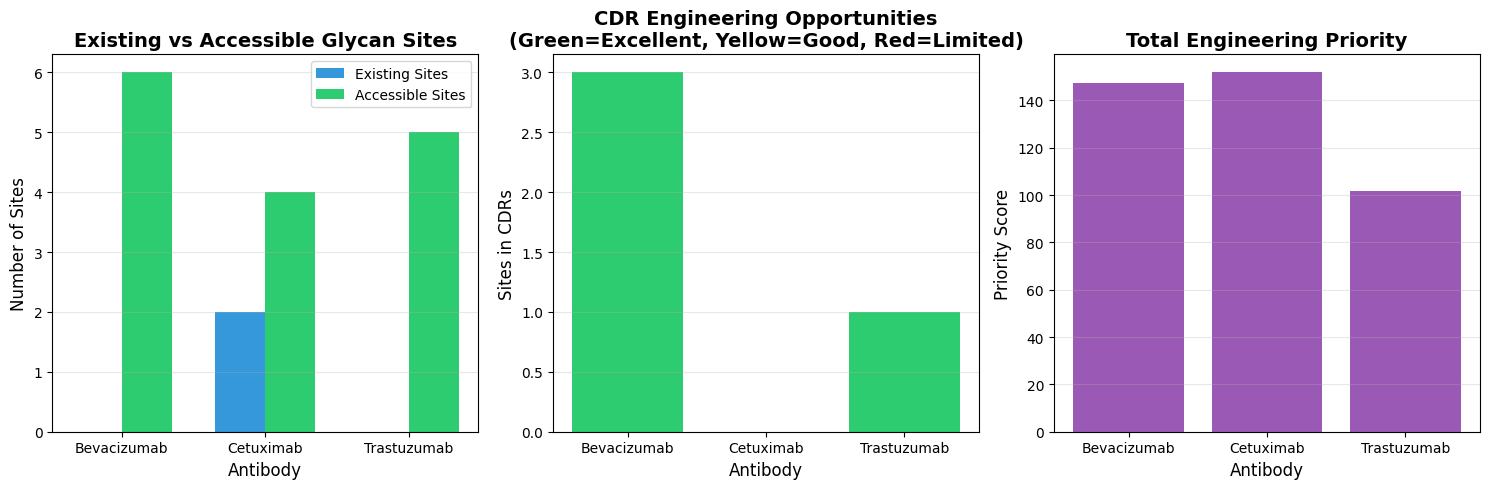


✓ Visualization saved as: glycan_engineering_opportunities.png


In [9]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

antibodies = [name.capitalize() for name in results.keys()]

# Plot 1: Site counts
existing_counts = [results[name]['total_existing_sites'] for name in results.keys()]
accessible_counts = [results[name]['total_accessible_sites'] for name in results.keys()]

x = np.arange(len(antibodies))
width = 0.35

axes[0].bar(x - width/2, existing_counts, width, label='Existing Sites', color='#3498db')
axes[0].bar(x + width/2, accessible_counts, width, label='Accessible Sites', color='#2ecc71')
axes[0].set_xlabel('Antibody', fontsize=12)
axes[0].set_ylabel('Number of Sites', fontsize=12)
axes[0].set_title('Existing vs Accessible Glycan Sites', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(antibodies)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: CDR-localized opportunities
cdr_counts = [results[name]['total_cdr_sites'] for name in results.keys()]
colors = ['#2ecc71' if results[name]['engineering_assessment'] == 'EXCELLENT' else
          '#f39c12' if results[name]['engineering_assessment'] == 'GOOD' else '#e74c3c'
          for name in results.keys()]

axes[1].bar(antibodies, cdr_counts, color=colors)
axes[1].set_xlabel('Antibody', fontsize=12)
axes[1].set_ylabel('Sites in CDRs', fontsize=12)
axes[1].set_title('CDR Engineering Opportunities\n(Green=Excellent, Yellow=Good, Red=Limited)',
                 fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Priority scores
priority_scores = [results[name]['total_priority_score'] for name in results.keys()]

axes[2].bar(antibodies, priority_scores, color='#9b59b6')
axes[2].set_xlabel('Antibody', fontsize=12)
axes[2].set_ylabel('Priority Score', fontsize=12)
axes[2].set_title('Total Engineering Priority', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('glycan_engineering_opportunities.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as: glycan_engineering_opportunities.png")

---
# Workflow Integration: RFdiffusion → Engineering → MD Validation

## Complete Pipeline:

### 1. **RFdiffusion Design**
```python
# Generate antibody optimized for binding
rfdiffusion_sequence = generate_antibody(target_antigen)
```

### 2. **Scan for Engineering Sites** (This Notebook)
```python
scanner = GlycanEngineeringScanner()
result = scanner.scan_antibody(heavy_chain, light_chain)

# Get top 3 mutations to test
top_mutations = get_top_mutations(result, n=3)
# Example output: ['D28N', 'N35T', 'V73T']
```

### 3. **Generate Variants**
```python
# Create mutated sequences
variants = [
    apply_mutation(original_seq, 'D28N'),
    apply_mutation(original_seq, 'N35T'),
    apply_mutation(original_seq, 'D28N+N35T')  # Combination
]
```

### 4. **MD Simulation Validation**
```python
# For each variant:
# 1. Add glycan structure at engineered site
# 2. Run MD simulation (AMBER/GROMACS)
# 3. Calculate MM/PBSA binding free energy
# 4. Compare to original RFdiffusion design

for variant in variants:
    # Add glycan
    glycosylated_structure = add_glycan(variant, glycan_type='complex')
    
    # MD simulation
    trajectory = run_md_simulation(
        structure=glycosylated_structure,
        duration='100ns',
        ensemble='NPT'
    )
    
    # Binding analysis
    binding_energy = calculate_mmpbsa(trajectory, target_antigen)
    
    # Compare to original
    if binding_energy <= original_binding_energy:
        print(f"✓ {variant}: Maintained/improved binding")
        candidates.append(variant)
```

### 5. **Select Best Variant**
```python
# Rank by:
# 1. Binding affinity preservation
# 2. Predicted developability (aggregation, solubility)
# 3. Manufacturing considerations

best_variant = rank_candidates(candidates)
```

---

## Key Advantages:

✅ **RFdiffusion** optimizes binding  
✅ **Your Scanner** identifies accessible PTM sites  
✅ **MD Validation** ensures functional compatibility  
✅ **Result:** Antibodies optimized for BOTH physics AND chemistry

---

## Business Value:

**Problem:** ML-designed antibodies fail 60-80% of the time during expression due to PTM issues

**Solution:** Pre-engineer strategic glycosylation before wet lab testing

**Impact:**
- 🎯 Improve ML design success rates from 20-40% → 60-80%
- 💰 Save $10-50M per therapeutic program
- ⏱️ Accelerate development by 6-12 months
- 🏭 Enhance manufacturability and reduce batch variability

---

## Contact

**Christopher Gaughan, PhD**  
Chemical & Biochemical Engineering  
AntibodyML Consulting LLC  

Email: chris@antibodyml.com  
Web: www.antibodyml.com

---

*Bridging the gap between computational design and cellular reality.*